## Finding similar words and analogies with word embeddings

In [34]:
!pip install -qU gluonnlp awscli botocore boto3 --upgrade

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [67]:
import mxnet as mx
from mxnet import nd
import gluonnlp as nlp

### Cosine similarity

Cosine similarity is the normalized dot product of two vectors:
  * colinear vectors --> close to +1 : words are used in the same context
  * opposite vectors --> close to -1 : words are used in a different context

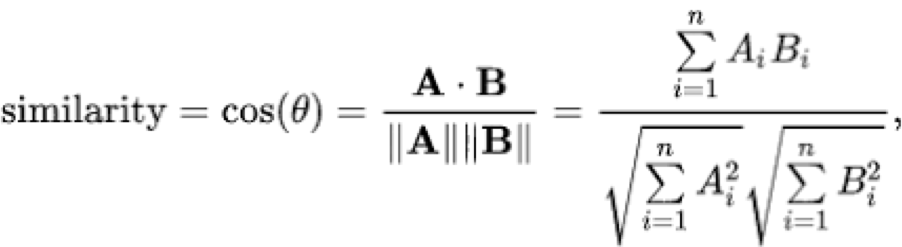

In [36]:
from IPython.display import Image
Image("cosine.png")
# Source: Wikipedia

In [37]:
def cos_similarity(embedding, word1, word2):
    vec1, vec2 = embedding[word1], embedding[word2]
    return mx.nd.dot(vec1, vec2) / (vec1.norm() * vec2.norm())

### Comparing word embeddings

Glove is a popular algorithm for word embeddings. Let's see which pre-trained embeddings are available in GluonNLP.

In [43]:
nlp.embedding.list_sources('glove')     # we could alo use 'fasttext' and 'word2vec'

['glove.42B.300d',
 'glove.6B.100d',
 'glove.6B.200d',
 'glove.6B.300d',
 'glove.6B.50d',
 'glove.840B.300d',
 'glove.twitter.27B.100d',
 'glove.twitter.27B.200d',
 'glove.twitter.27B.25d',
 'glove.twitter.27B.50d']

Let's download embeddings built from a 6-billion word corpus encoded in 50-dimension.

In [101]:
glove = nlp.embedding.create('glove', source='glove.6B.50d')

Let's build the vocabulary for that corpus.

In [102]:
vocab = nlp.Vocab(nlp.data.Counter(glove.idx_to_token))
vocab.set_embedding(glove)

In [103]:
len(vocab)

400004

These are the two words we'd like to compare.

In [87]:
word1 = 'burger'
word2 = 'fries'

Let's print their embeddings.

In [88]:
print(vocab.embedding[word1])
print(vocab.embedding[word2])


[ 0.36973   -1.1797    -0.92375    0.034749   0.61164    0.24154
 -0.32643   -0.2738     0.64008    0.1221    -0.28096    0.66651
 -0.48707    0.40504    0.35369    0.18425    0.23621   -0.25309
 -0.066385  -0.39027    0.65472   -0.66727   -0.057554   1.0579
 -1.0032    -0.5303    -0.70431   -0.0086647  0.088907  -0.41935
  0.50855    0.18892    0.22315    1.7206     0.20125   -0.37637
  0.13816    0.49756    0.38932    0.19766    0.36049    0.9203
 -0.33094    0.0070863  0.43877    1.4078    -0.64715   -0.54113
  0.21458    0.8122   ]
<NDArray 50 @cpu(0)>

[ 0.28549   -0.50842   -0.97154   -0.92191    0.79827    0.47291
 -0.52855   -0.30383   -0.22146   -0.0066011 -0.084924   1.0594
  0.83255    0.53102    0.37249    0.25727   -0.16391   -0.16185
  0.0044215 -0.49747    0.41993   -0.97901    0.6449     0.71762
 -0.54787   -0.50341   -0.66512    0.24811    0.92945   -0.19581
  0.31261    0.54807   -0.27032    1.8846    -0.22892   -0.20775
 -0.2102     1.0086     0.96226    0.52246    

Now let's compute their cosine similarity.

In [89]:
print('Similarity:', cos_similarity(glove, word1, word2).asnumpy()[0])

Similarity: 0.79689014


### Finding words that have a similar meaning

We need a simple way to compute the dot product of a given embedding with respect to all other embeddings, and select the top values.

First, we need to normalize all embeddings, to make sure all dot products will be in the [-1, +1] range.

In [63]:
def norm_vecs_by_row(x):
    return x / nd.sqrt(nd.sum(x * x, axis=1) + 1E-10).reshape((-1,1))

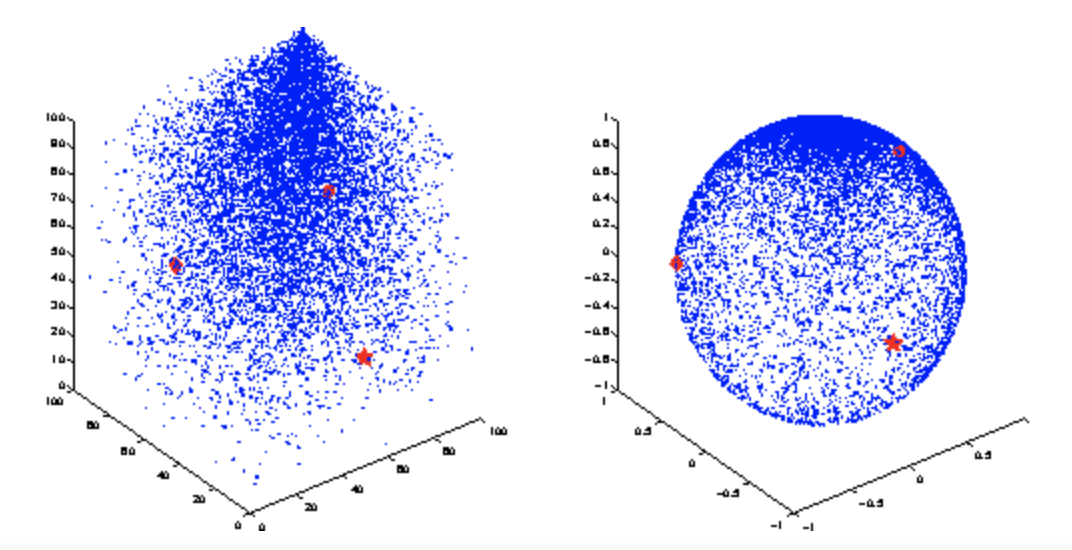

In [64]:
Image("normalized vectors.png")
# Source: "Normalized Word Embedding and Orthogonal Transform for Bilingual Word Translation", Xing et al, 2015

This function computes the dot products for a given word, and return the top 'k' ones. We use the NDArray API from Apache MXNet.

In [73]:
def get_k_nearest_words(vocab, k, word):
    word_vec = vocab.embedding[word].reshape((-1, 1))
    vocab_vecs = norm_vecs_by_row(vocab.embedding.idx_to_vec)
    dot_prod = nd.dot(vocab_vecs, word_vec)
    indices = nd.topk(dot_prod.reshape((len(vocab), )), k=k+1, ret_typ='indices')
    indices = [int(i.asscalar()) for i in indices]
    # Remove unknown and input tokens.
    return vocab.to_tokens(indices[1:])

In [85]:
get_k_nearest_words(vocab, 5, 'burger')

['fries', 'burgers', 'kfc', 'pizza', 'taco']

Of course, we could do the opposite, and pick the 'k' smallest values to find unrelated words.

In [77]:
def get_k_furthest_words(vocab, k, word):
    word_vec = vocab.embedding[word].reshape((-1, 1))
    vocab_vecs = norm_vecs_by_row(vocab.embedding.idx_to_vec)
    dot_prod = nd.dot(vocab_vecs, word_vec)
    indices = nd.topk(dot_prod.reshape((len(vocab), )), k=k+1, ret_typ='indices', is_ascend=True)
    indices = [int(i.asscalar()) for i in indices]
    # Remove unknown and input tokens.
    return vocab.to_tokens(indices[1:])

In [86]:
get_k_furthest_words(vocab, 5, 'burger')

['summited', 'pizzey', 'amadablam', 'nthu', '92.41']

### Finding analogies

If the distance between vector1 and vector2 is close to the distance between vector3 and vector4, then (word1, word2) and (word3, word4) illustrate a similar relationship.

This function takes three words as input: it literally computes vector2 - vector1 + vector3, computes the dot product of the resulting vector with all other embeddings, and return the top 'k' values.

In [90]:
def get_top_k_by_analogy(vocab, k, word1, word2, word3):
    word_vecs = vocab.embedding[word1, word2, word3]
    word_diff = (word_vecs[1] - word_vecs[0] + word_vecs[2]).reshape((-1, 1))
    vocab_vecs = norm_vecs_by_row(vocab.embedding.idx_to_vec)
    dot_prod = nd.dot(vocab_vecs, word_diff)
    indices = nd.topk(dot_prod.reshape((len(vocab), )), k=k, ret_typ='indices')
    indices = [int(i.asscalar()) for i in indices]
    return vocab.to_tokens(indices)

In [128]:
get_top_k_by_analogy(vocab, 1, 'cold', 'colder', 'warm')

['warmer']

In [131]:
get_top_k_by_analogy(vocab, 1, 'king', 'man', 'queen')

['woman']

In [137]:
get_top_k_by_analogy(vocab, 1, 'cars', 'ferrari', 'jewelry')

['bulgari']